In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from backpack import backpack, extend
from backpack.extensions import DiagGGNExact

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from utils_2d import *

from tqdm import tqdm

from copy import deepcopy
import random
import time

sns.set()


torch.cuda.is_available()

True

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

set_seed(42)

# Uncertainty Experiments

### The following experiments are to examine the effects of some different approaches to uncertainty quantification using an artificial 2D dataset that can provide some visual intuition ( which as is well-known will likely not hold in higher dimensions). We beginning by generating some data.

### Data is generated as Gaussian blobs, which are then assigned to classes, which gives us a binary classification settings.

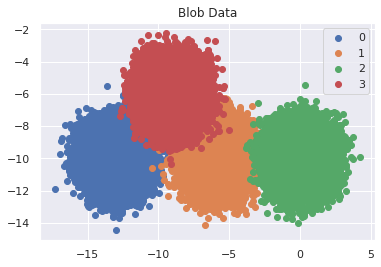

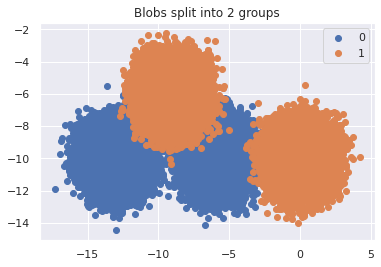

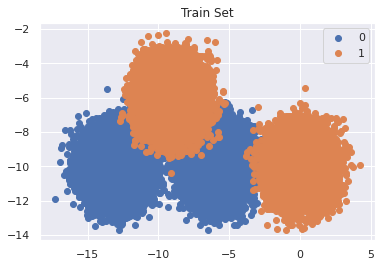

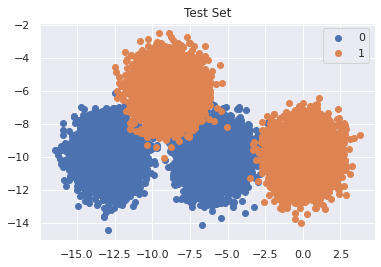

In [3]:
X_train, X_test, y_train, y_test = get_binary_blobs(centers = [[-13, -10],[-6,-10],[0,-10],[-9,-6]])

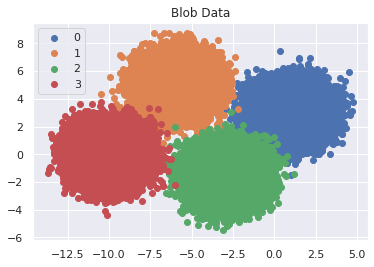

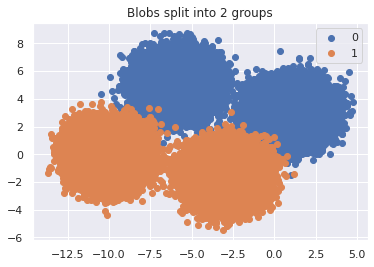

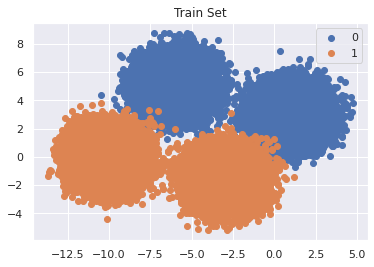

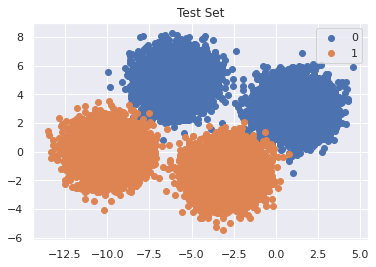

In [4]:
X_tr2, X_t2, y_tr2, y_t2 = get_binary_blobs(centers = [[1,3],[-6,5],[-3,-1.5],[-10,0]])

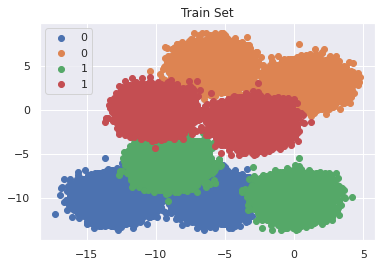

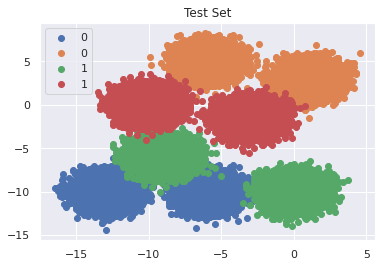

In [5]:
for i in range(2):
    plt.scatter(X_train[y_train == i,0], X_train[y_train == i,1], label = i)
    plt.scatter(X_tr2[y_tr2 == i,0], X_tr2[y_tr2 == i,1], label = i)
plt.title("Train Set")
plt.legend()
plt.show()

for i in range(2):
    plt.scatter(X_test[y_test == i,0], X_test[y_test == i,1], label = i)
    plt.scatter(X_t2[y_t2 == i,0], X_t2[y_t2 == i,1], label = i)
plt.title("Test Set")
plt.legend()
plt.show()

In [6]:
scaler = StandardScaler()
X_train = np.concatenate([X_train, X_tr2])
y_train = np.concatenate([y_train, y_tr2])
X_test = np.concatenate([X_test, X_t2])
y_test = np.concatenate([y_test, y_t2])
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Uncertainty via Seed Ensembles

### This first approach is based on the following paper from Deepmind.

### "Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf

### The approach is relatively straightforward. Train N neural networks using the same architecture and settings, but change the random seed. This can be interpreted as giving us samples from the posterior predictive distribution. Averaging the N neural networks gives us an ensemble estimate, and taking the variance or standard deviation provides an estimate of predictive uncertainty.

### I found this approach quite appealing, since 1) the N neural networks can be trained in parallel and 2) this allows us to sample from different modes in weight space. Additionally, a study of various uncertainty quantification methods found the ensemble approach to work quite well, even under data shift. https://arxiv.org/pdf/1906.02530.pdf

In [7]:
def get_tensor_dataset(X, y):
    y = y.reshape(-1,1)
    return TensorDataset(torch.Tensor(X), torch.Tensor(y))


def train_model(seed = None):
    if seed is not None:
        set_seed(seed)

    model = nn.Sequential(nn.Linear(2, 20),
                          nn.ReLU(),
                          nn.Linear(20, 10),
                          nn.ReLU(),
                          nn.Linear(10, 1),
                          nn.Sigmoid())

    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train_norm, y_train),
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 2, 
                                              worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(seed = None):
    start = time.perf_counter()
    net = train_model(seed)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    plot_decision_boundary(net, scaler, X_test, y_test)
    return net

Training model 1
[1,   586] loss: 0.029
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 34.00021744007245 sec
AUC: 0.9999486395485402
MSE: 0.002382357530674416


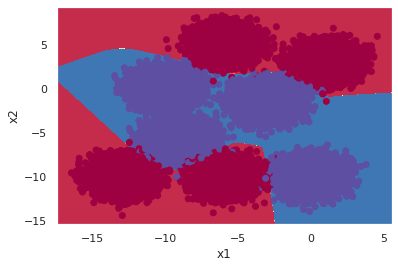

Training model 2
[1,   586] loss: 0.030
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 34.199205662007444 sec
AUC: 0.9999461050473062
MSE: 0.0023505881826374466


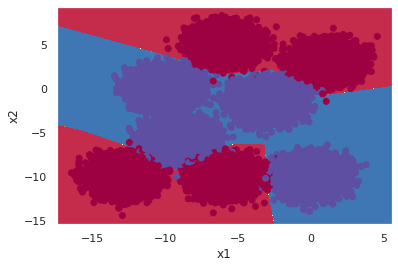

Training model 3
[1,   586] loss: 0.030
[2,   586] loss: 0.004
[3,   586] loss: 0.003
[4,   586] loss: 0.002
[5,   586] loss: 0.002
[6,   586] loss: 0.002
[7,   586] loss: 0.002
[8,   586] loss: 0.002
[9,   586] loss: 0.002
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 33.78269055101555 sec
AUC: 0.999945877838231
MSE: 0.002346774194692973


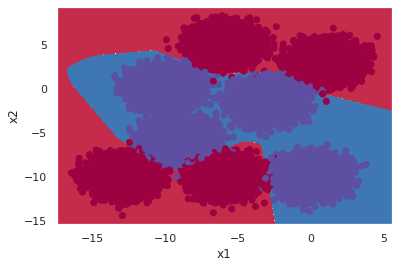

Training model 4
[1,   586] loss: 0.035
[2,   586] loss: 0.010
[3,   586] loss: 0.006
[4,   586] loss: 0.004
[5,   586] loss: 0.003
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 33.46277456602547 sec
AUC: 0.9999257394338548
MSE: 0.002342978514016705


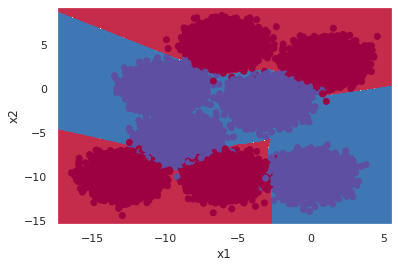

Training model 5
[1,   586] loss: 0.023
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 33.8606348260073 sec
AUC: 0.9999437065515046
MSE: 0.002464119776832316


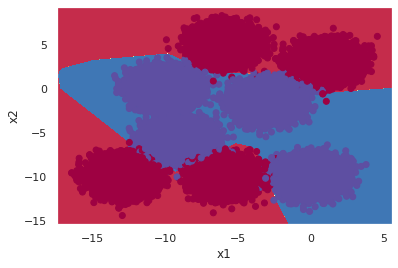

Training model 6
[1,   586] loss: 0.026
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.71276666701306 sec
AUC: 0.9999204712234298
MSE: 0.0028627820464232697


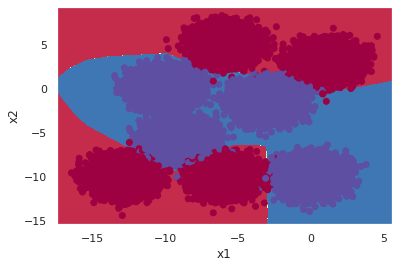

Training model 7
[1,   586] loss: 0.025
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.002
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.56803328206297 sec
AUC: 0.999932375698923
MSE: 0.002599810718100176


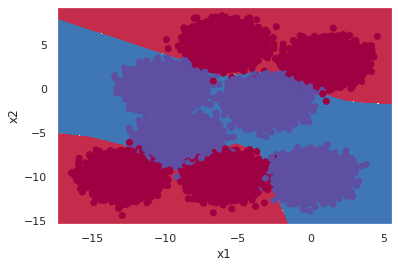

Training model 8
[1,   586] loss: 0.028
[2,   586] loss: 0.004
[3,   586] loss: 0.003
[4,   586] loss: 0.003
[5,   586] loss: 0.002
[6,   586] loss: 0.002
[7,   586] loss: 0.002
[8,   586] loss: 0.002
[9,   586] loss: 0.002
[10,   586] loss: 0.002
[11,   586] loss: 0.002
[12,   586] loss: 0.002
[13,   586] loss: 0.002
[14,   586] loss: 0.002
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 36.023947312962264 sec
AUC: 0.9999453034152871
MSE: 0.0026931768881782903


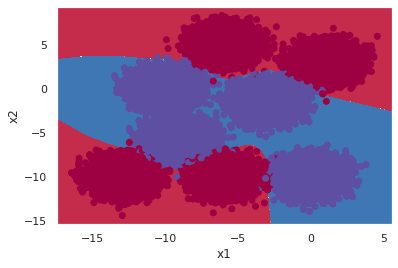

Training model 9
[1,   586] loss: 0.025
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.30850907799322 sec
AUC: 0.9999383159361903
MSE: 0.002557990749497795


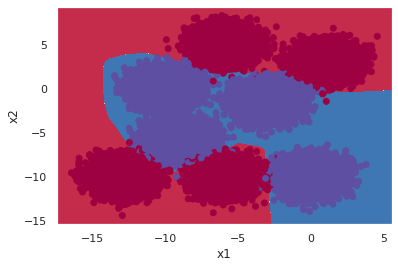

Training model 10
[1,   586] loss: 0.027
[2,   586] loss: 0.003
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.890567737980746 sec
AUC: 0.999948821955826
MSE: 0.0023479312342103214


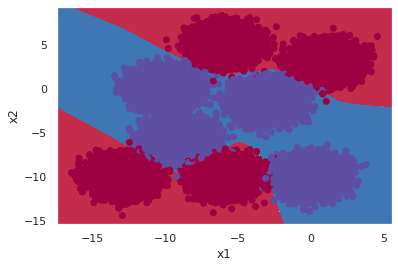

In [10]:
models = []
for i in range(10):
    print(f"Training model {i+1}")
    models.append(train_then_plot(seed = i + 42))

In [11]:
def plot_uncertainty(models, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    scores = []
    for model in models:
        if torch.cuda.is_available():
            Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
            Z = Z.cpu().detach().numpy().reshape(xx.shape)
        else:
            Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])))
            Z = Z.detach().numpy().reshape(xx.shape)
        scores.append(Z)
    ensemble_scores = np.mean(np.array(scores), axis = 0)
    uncertainty = np.std(np.array(scores), axis = 0)
    plt.contourf(xx, yy, ensemble_scores, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Ensemble Predictions")
    
    plt.show()
    
    plt.contourf(xx, yy, uncertainty, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Uncertainty")
    
    plt.show()


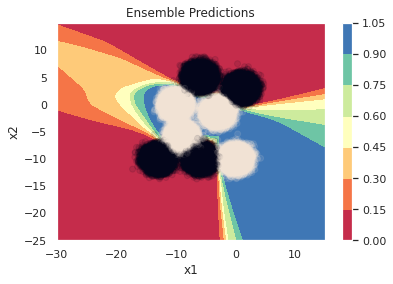

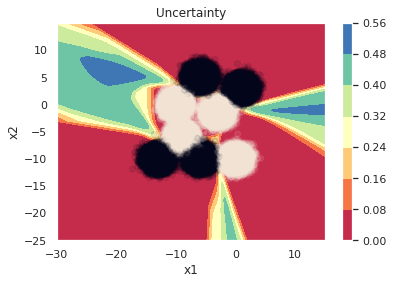

In [12]:
plot_uncertainty(models)

### The uncertainty estimates seem reasonable. In particular, we notice higher uncertainty in regions where samples from both classes are closer together. However, we may desire that uncertainty increases as we get further away from the training data, and this does not always appear to happen. That could be reasonable, but let's try some other methods.

# Autoencoder Reconstruction Error

### This technique is more for outlier detection, as opposed to uncertainty estimation, but it should be useful for detecting data that is out-of-distribution to a significant degree. We simply train an autoencoder, and measure the L2 reconstruction error.

In [13]:
def train_autoencoder(seed = None):
    if seed is not None:
        set_seed(seed)
        

    model = nn.Sequential(nn.Linear(2, 4),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 4),
                          nn.ReLU(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 2))
    
    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train_norm, y_train), batch_size = batch_size,
                                          shuffle = True, num_workers = 2, worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()
    

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

In [14]:
autoencoder = train_autoencoder( seed = 42)

[1,   586] loss: 0.142
[2,   586] loss: 0.078
[3,   586] loss: 0.072
[4,   586] loss: 0.069
[5,   586] loss: 0.067
[6,   586] loss: 0.066
[7,   586] loss: 0.065
[8,   586] loss: 0.065
[9,   586] loss: 0.065
[10,   586] loss: 0.065
[11,   586] loss: 0.065
[12,   586] loss: 0.066
[13,   586] loss: 0.065
[14,   586] loss: 0.065
[15,   586] loss: 0.065
[16,   586] loss: 0.065
[17,   586] loss: 0.065
[18,   586] loss: 0.065
[19,   586] loss: 0.065
[20,   586] loss: 0.065
Finished Training


In [15]:
def plot_misalignment(model, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    
    if torch.cuda.is_available():
        Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
        Z = Z.cpu().detach().numpy()
    else:
        Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])))
        Z = Z.detach().numpy()

    Z = np.sum((Z - scaler.transform(np.c_[xx.ravel(), yy.ravel()])) ** 2, axis = 1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Autoencoder Misalignment")
    
    plt.show()

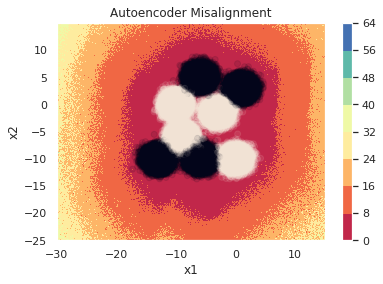

In [16]:
plot_misalignment(autoencoder)

### As expected the autoencoder is useful for indicating when we are far from the training data. However, it is not good at indicating uncertainty in the case of data being near the decision boundary.

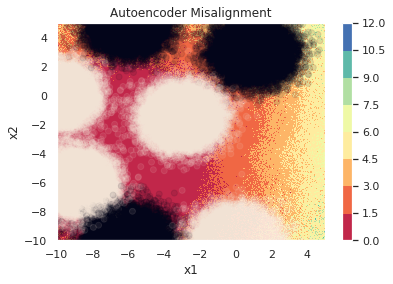

In [17]:
plot_misalignment(autoencoder, -10, 5, -10, 5, restrict = True)

In [18]:
def plot_encoder(model, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    
    if torch.cuda.is_available():
        Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
        Z = Z.cpu().detach().numpy()
    else:
        Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])))
        Z = Z.detach().numpy()

    Z = scaler.inverse_transform(Z)
    plt.scatter(Z[:,0],
                Z[:,1])
    plt.scatter(X_train[:,0],
                X_train[:,1],
                alpha = 0.1)
    plt.plot([xmin, xmax], [ymin, ymin], linestyle = '--', c = 'k')
    plt.plot([xmin, xmax], [ymax, ymax], linestyle = '--', c = 'k')
    plt.plot([xmin, xmin], [ymin, ymax], linestyle = '--', c = 'k')
    plt.plot([xmax, xmax], [ymin, ymax], linestyle = '--', c = 'k')
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Autoencoder Mapping")
    
    plt.show()

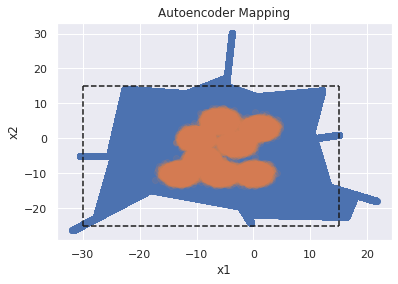

In [19]:
plot_encoder(autoencoder)

### The deep ensemble approach yielded regions far from the training data that had high predictive certainty. Could this be related to our choice of ReLu activation functions? It has been shown that the function represented by a MLP with ReLu activations is finite (although it can be much greater for deeper architectures vs shallow https://arxiv.org/pdf/1312.6098.pdf), so can we getter more refined uncertainty estimates with tanh activations. Probably not to any significant degree, but let's try!

In [20]:
def train_model(seed = None):
    if seed is not None:
        set_seed(seed)

    model = nn.Sequential(nn.Linear(2, 20),
                          nn.Tanh(),
                          nn.Linear(20, 10),
                          nn.Tanh(),
                          nn.Linear(10, 1),
                          nn.Sigmoid())

    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train_norm, y_train),
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 2, 
                                              worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(seed = None):
    start = time.perf_counter()
    net = train_model(seed)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    plot_decision_boundary(net, scaler, X_test, y_test)
    return net

Training model 1
[1,   586] loss: 0.032
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.21032335201744 sec
AUC: 0.9999348005957793
MSE: 0.0024209753846652425


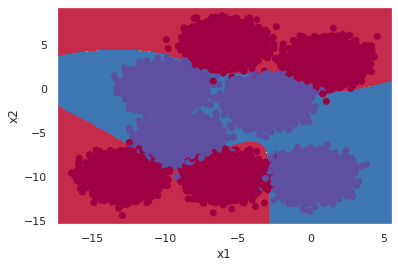

Training model 2
[1,   586] loss: 0.035
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 36.41059383493848 sec
AUC: 0.9999461722499904
MSE: 0.002306950422794988


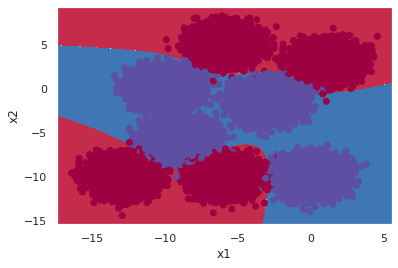

Training model 3
[1,   586] loss: 0.035
[2,   586] loss: 0.005
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.66251470800489 sec
AUC: 0.999943325736294
MSE: 0.00234025924667646


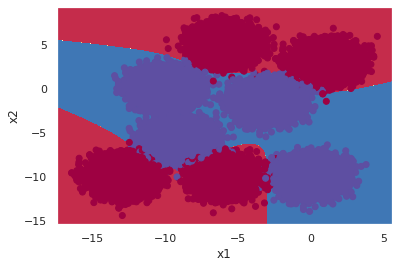

Training model 4
[1,   586] loss: 0.037
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.507613652036525 sec
AUC: 0.9999100652077885
MSE: 0.0026049284004675617


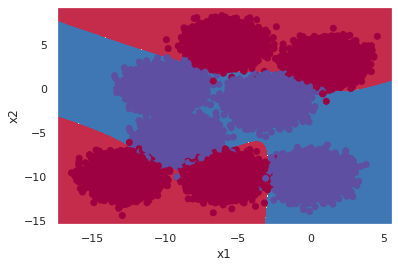

Training model 5
[1,   586] loss: 0.029
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.001
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.824895933968946 sec
AUC: 0.9999440153638393
MSE: 0.0022998951480442823


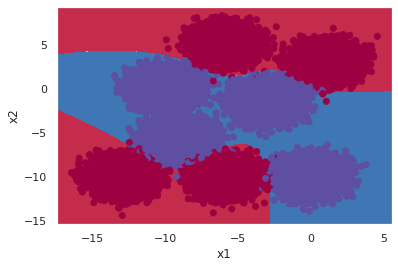

Training model 6
[1,   586] loss: 0.034
[2,   586] loss: 0.005
[3,   586] loss: 0.003
[4,   586] loss: 0.002
[5,   586] loss: 0.002
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.30322090606205 sec
AUC: 0.9999429097196771
MSE: 0.0024173363171288375


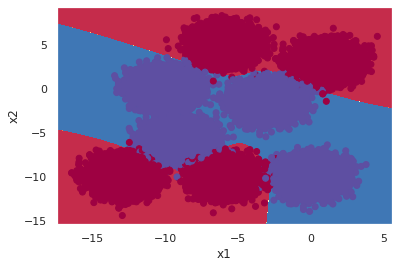

Training model 7
[1,   586] loss: 0.031
[2,   586] loss: 0.004
[3,   586] loss: 0.003
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 36.598218653933145 sec
AUC: 0.9999447393927587
MSE: 0.002350700408116995


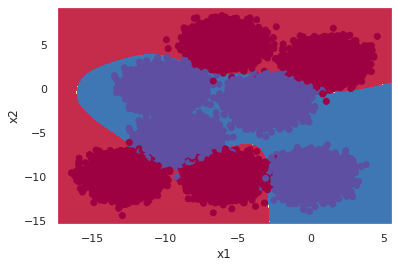

Training model 8
[1,   586] loss: 0.035
[2,   586] loss: 0.005
[3,   586] loss: 0.003
[4,   586] loss: 0.002
[5,   586] loss: 0.002
[6,   586] loss: 0.002
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.78448323300108 sec
AUC: 0.999928574747104
MSE: 0.002737655984709428


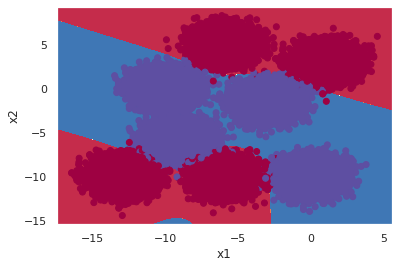

Training model 9
[1,   586] loss: 0.028
[2,   586] loss: 0.004
[3,   586] loss: 0.002
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 36.58183971000835 sec
AUC: 0.9999248577986403
MSE: 0.002537344001555646


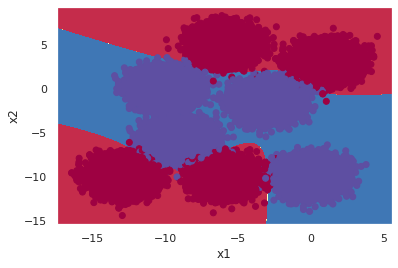

Training model 10
[1,   586] loss: 0.036
[2,   586] loss: 0.005
[3,   586] loss: 0.003
[4,   586] loss: 0.002
[5,   586] loss: 0.001
[6,   586] loss: 0.001
[7,   586] loss: 0.001
[8,   586] loss: 0.001
[9,   586] loss: 0.001
[10,   586] loss: 0.001
[11,   586] loss: 0.001
[12,   586] loss: 0.001
[13,   586] loss: 0.001
[14,   586] loss: 0.001
[15,   586] loss: 0.001
[16,   586] loss: 0.001
[17,   586] loss: 0.001
[18,   586] loss: 0.001
[19,   586] loss: 0.001
[20,   586] loss: 0.001
Finished Training
Train time: 35.46787439507898 sec
AUC: 0.999936787875156
MSE: 0.002430232311391668


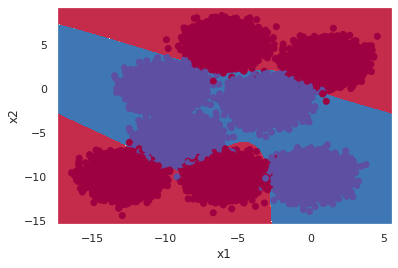

In [21]:
models = []
for i in range(10):
    print(f"Training model {i+1}")
    models.append(train_then_plot(seed = i + 42))

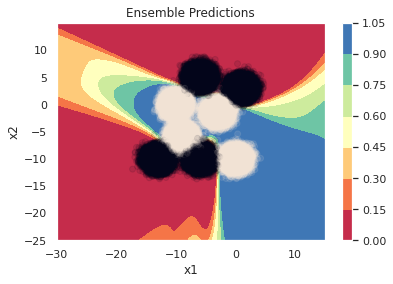

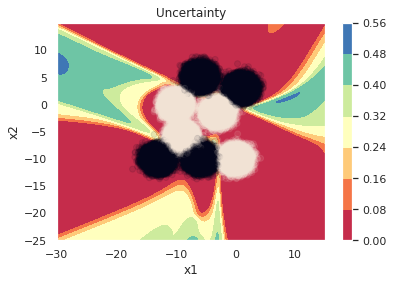

In [22]:
scores = plot_uncertainty(models)

### Qualitatively, the tanh uncertainty estimates do look a little better. Of course this is not very rigorous, but interesting none the less.

In [23]:
def train_autoencoder(seed = None):
    if seed is not None:
        set_seed(seed)
        

    model = nn.Sequential(nn.Linear(2, 4),
                          nn.Tanh(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 4),
                          nn.Tanh(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 2))
    
    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train_norm, y_train), batch_size = batch_size,
                                          shuffle = True, num_workers = 2, worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()
    

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

In [24]:
autoencoder = train_autoencoder( seed = 42)

[1,   586] loss: 0.096
[2,   586] loss: 0.035
[3,   586] loss: 0.031
[4,   586] loss: 0.030
[5,   586] loss: 0.029
[6,   586] loss: 0.029
[7,   586] loss: 0.029
[8,   586] loss: 0.029
[9,   586] loss: 0.029
[10,   586] loss: 0.029
[11,   586] loss: 0.028
[12,   586] loss: 0.029
[13,   586] loss: 0.028
[14,   586] loss: 0.028
[15,   586] loss: 0.028
[16,   586] loss: 0.028
[17,   586] loss: 0.028
[18,   586] loss: 0.028
[19,   586] loss: 0.028
[20,   586] loss: 0.028
Finished Training


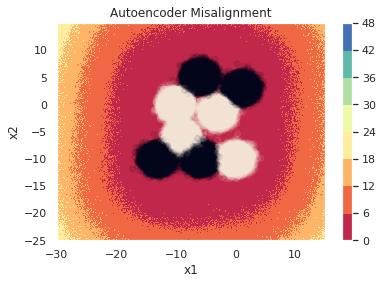

In [25]:
plot_misalignment(autoencoder)

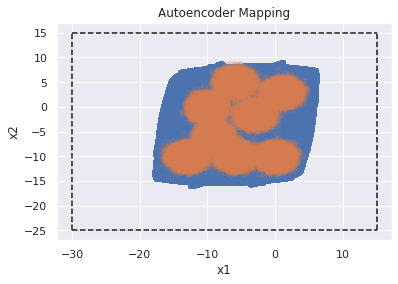

In [26]:
plot_encoder(autoencoder)

### The difference in the autoencoder mapping is quite striking between ReLu and tanh activations!

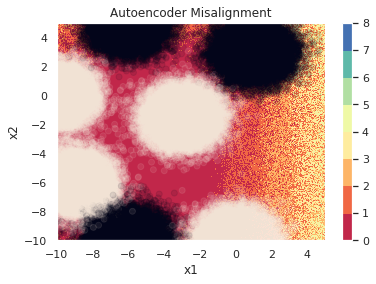

In [27]:
plot_misalignment(autoencoder, -10, 5, -10, 5, restrict = True)

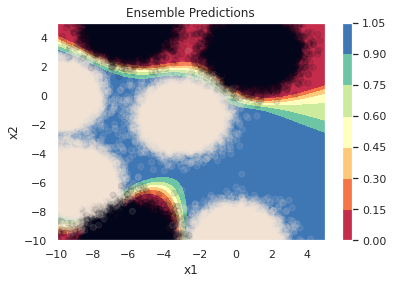

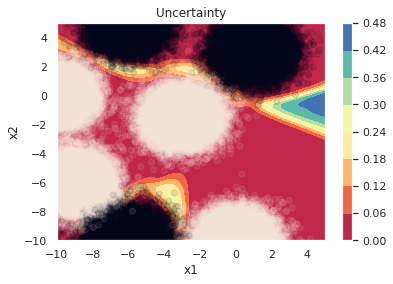

In [28]:
plot_uncertainty(models, -10, 5, -10, 5, restrict = True)

### Again, we see the benefit of the deep ensemble approach when near decision boundaries.

### Perhaps the most popular recent approach (as measured by citations) to neural network uncertainty estimation comes from Yarin Gal and Zoubin Ghahramani, https://arxiv.org/pdf/1506.02142.pdf. Their approach shows that dropout can give us a reasonably justified and efficient means of sampling from the posterior predictive distribution.

### It's hard to beat the efficiency of this approach, particularly in terms of both memory and compute. However, it does seem to be sampling more from a single mode of the predictive distribution. Let's see how it looks!

In [29]:
def train_model(seed = None):
    if seed is not None:
        set_seed(seed)

    model = nn.Sequential(nn.Linear(2, 20),
                          nn.Tanh(),
                          nn.Dropout(0.2),
                          nn.Linear(20, 10),
                          nn.Tanh(),
                          nn.Dropout(0.2),
                          nn.Linear(10, 1),
                          nn.Sigmoid())

    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_train_norm, y_train),
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 2, 
                                              worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(seed = None):
    start = time.perf_counter()
    net = train_model(seed)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    net.eval()
    plot_decision_boundary(net, scaler, X_test, y_test)
    return net

[1,   586] loss: 0.045
[2,   586] loss: 0.017
[3,   586] loss: 0.012
[4,   586] loss: 0.010
[5,   586] loss: 0.008
[6,   586] loss: 0.007
[7,   586] loss: 0.007
[8,   586] loss: 0.006
[9,   586] loss: 0.006
[10,   586] loss: 0.006
[11,   586] loss: 0.005
[12,   586] loss: 0.005
[13,   586] loss: 0.005
[14,   586] loss: 0.005
[15,   586] loss: 0.005
[16,   586] loss: 0.004
[17,   586] loss: 0.004
[18,   586] loss: 0.004
[19,   586] loss: 0.004
[20,   586] loss: 0.004
Finished Training
Train time: 38.26749983499758 sec
AUC: 0.9998288795650391
MSE: 0.004606821187741959


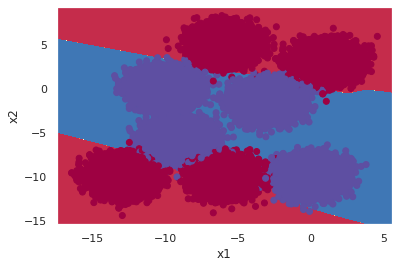

In [30]:
model = train_then_plot(seed = 42)

In [31]:
def plot_uncertainty(model, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    scores = []
    model.eval()
    for m in model.modules():
      if m.__class__.__name__.startswith('Dropout'):
        m.train()
    for _ in range(10):
        if torch.cuda.is_available():
            Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
            Z = Z.cpu().detach().numpy().reshape(xx.shape)
        else:
            Z = model(torch.Tensor(scaler.transform(np.c_[xx.ravel(), yy.ravel()])))
            Z = Z.detach().numpy().reshape(xx.shape)
        scores.append(Z)
    ensemble_scores = np.mean(np.array(scores), axis = 0)
    uncertainty = np.std(np.array(scores), axis = 0)
    plt.contourf(xx, yy, ensemble_scores, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Ensemble Predictions")
    
    plt.show()
    
    plt.contourf(xx, yy, uncertainty, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Uncertainty")
    
    plt.show()

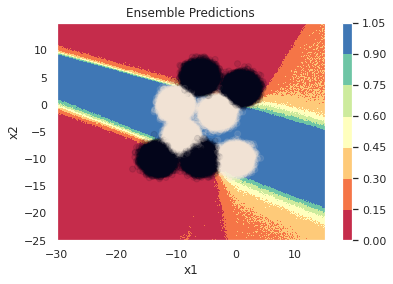

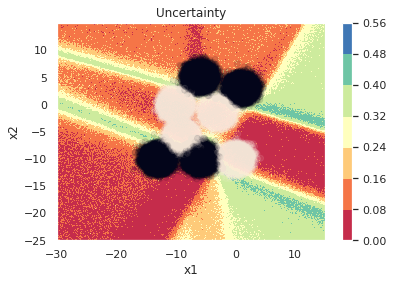

In [32]:
plot_uncertainty(model)

### Hmmmm... not quite sure what to make of the uncertainty estimates. They don't seem nearly as reasonable as the deep ensemble approach, but perhaps I'm missing something in my implementation.

### Autoencoders seem to reliably spot the very out-of-distribution data points, but let's take a look at one other outlier-type method. This one showed that a very simple aproach can yield surprisingly good outlier estimates. The idea is to simply take a small sample from the train set, then at test time find the minimum distance from a given point to a point in the sample.

### Here's the paper:
https://papers.nips.cc/paper/2013/file/d296c101daa88a51f6ca8cfc1ac79b50-Paper.pdf


In [39]:
samples_idx = np.random.choice(X_train.shape[0], 20, replace=False)
samples = X_train[samples_idx]

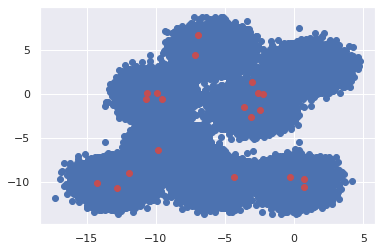

In [40]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(samples[:,0], samples[:,1], c = "r")
plt.show()

### The original paper used only 20 samples, so we've done the same. However, it entirely missed one of the Gaussian blobs, and I would expect this to only get worse in high-dimensions.

### None the less, here's a nice numpy one-liner to get the pairwise distances and take the minimum.

In [60]:
def get_min_dist(x):
    dist = np.min(np.linalg.norm(x[:, None, :] - samples[None, :, :], axis = -1), axis = 1)
    return dist

In [61]:
get_min_dist(X_train)

array([2.52516313, 1.71106559, 0.51929376, ..., 1.48512943, 1.10449727,
       0.86667517])

In [64]:
def plot_dist(xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

    Z = get_min_dist(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X_train[:,0],
                X_train[:,1],
                c = y_train, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Sample Distance-Based Outlier Factor")
    
    plt.show()

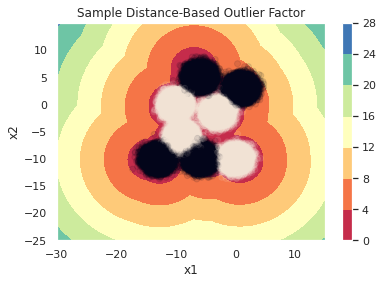

In [65]:
plot_dist()

### As expected based on the sample, an entire Gaussian blob gets higher values than the others, but perhaps this isn't such a big problem. Otherwise the methods looks to do a reasonable job on measuring outlierness.

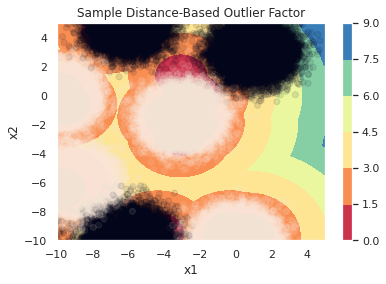

In [66]:
plot_dist(-10, 5, -10, 5, restrict = True)

In [68]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,2],[3,4],[5,6]])
np.concatenate([a,b])

array([[1, 2],
       [3, 4],
       [1, 2],
       [3, 4],
       [5, 6]])

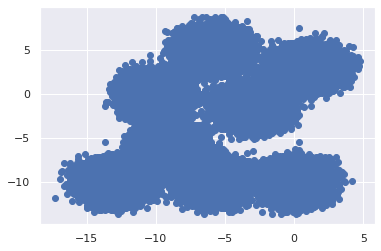

In [69]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.show()

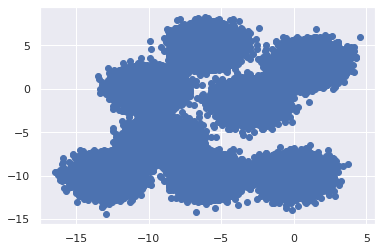

In [70]:
plt.scatter(X_test[:,0], X_test[:,1])
plt.show()

In [72]:
X_train[y_train<1].shape

(74842, 2)

In [73]:
X_train.shape

(150000, 2)

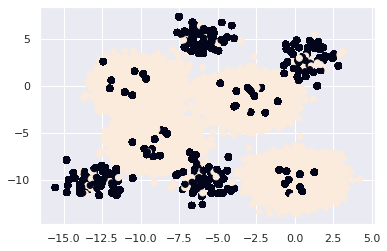

In [116]:
np.random.seed(21)
downsamples_idx = np.random.choice(X_train.shape[0], 500, replace=False)
y_downsample = y_train[downsamples_idx]
X_downsample = X_train[downsamples_idx][y_downsample == 0]
y_downsample = y_downsample[y_downsample == 0]
downsamples_idx = np.random.choice(X_train.shape[0], 100, replace=False)
y_temp = y_train[downsamples_idx]
X_temp = X_train[downsamples_idx][y_temp == 1]
y_temp = y_temp[y_temp == 1]
X_downsample = np.concatenate([X_downsample, X_temp])
y_downsample = np.concatenate([y_downsample, np.zeros(y_temp.shape)])
downsamples_idx = np.random.choice(X_downsample.shape[0], 50, replace=False)
y_downsample[downsamples_idx] = 1
X_upsample = [X_downsample] * 200
y_upsample = [y_downsample] * 200
X = np.concatenate([X_train[y_train == 1], *X_upsample])
y = np.concatenate([y_train[y_train == 1], *y_upsample])
plt.scatter(X[:,0], X[:,1], c = y) 
plt.show()

In [117]:
scaler2 = StandardScaler()
X_norm = scaler2.fit_transform(X)

In [118]:
def train_model(seed = None):
    if seed is not None:
        set_seed(seed)

    model = nn.Sequential(nn.Linear(2, 20),
                          nn.Tanh(),
                          nn.Linear(20, 10),
                          nn.Tanh(),
                          nn.Linear(10, 1),
                          nn.Sigmoid())

    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_norm, y),
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 2, 
                                              worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(seed = None):
    start = time.perf_counter()
    net = train_model(seed)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    plot_decision_boundary(net, scaler2, X, y)
    return net

Training model 1
[1,   537] loss: 0.045
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 36.36770930700004 sec
AUC: 0.8991794067893991
MSE: 0.10338197092193477


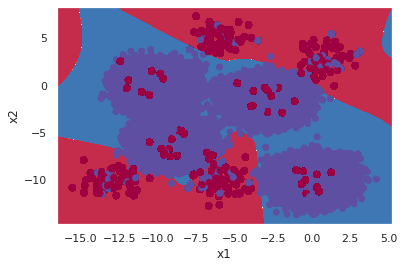

Training model 2
[1,   537] loss: 0.044
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.028
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 36.50799225002993 sec
AUC: 0.902992400243352
MSE: 0.10227031283368852


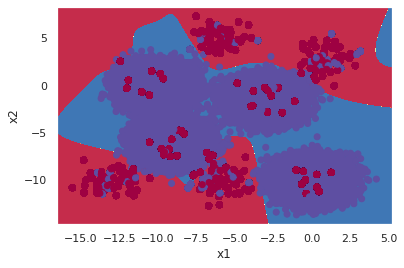

Training model 3
[1,   537] loss: 0.046
[2,   537] loss: 0.031
[3,   537] loss: 0.031
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.030
[7,   537] loss: 0.030
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.029
[11,   537] loss: 0.029
[12,   537] loss: 0.029
[13,   537] loss: 0.029
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 116.45964845397975 sec
AUC: 0.8979405556621863
MSE: 0.10402194208414958


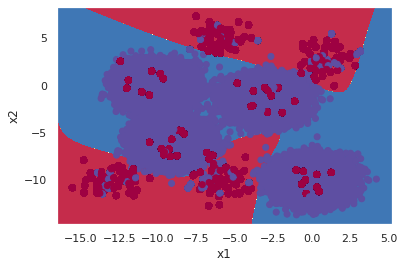

Training model 4
[1,   537] loss: 0.048
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.029
[11,   537] loss: 0.029
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 112.6741944149835 sec
AUC: 0.8994311587952942
MSE: 0.1034008359618711


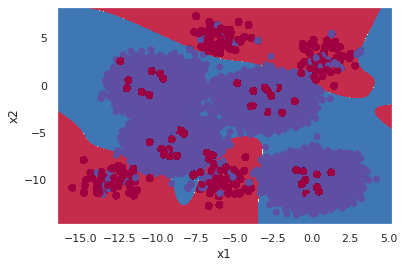

Training model 5
[1,   537] loss: 0.044
[2,   537] loss: 0.031
[3,   537] loss: 0.031
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.028
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 111.05992877599783 sec
AUC: 0.9002454441457883
MSE: 0.10311408671821662


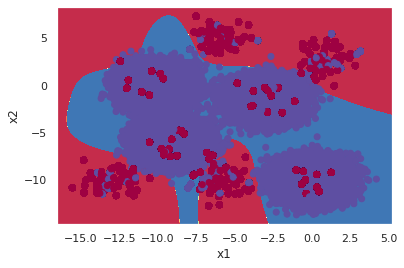

Training model 6
[1,   537] loss: 0.047
[2,   537] loss: 0.032
[3,   537] loss: 0.031
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 111.61669013206847 sec
AUC: 0.8986693564605942
MSE: 0.1033419624114653


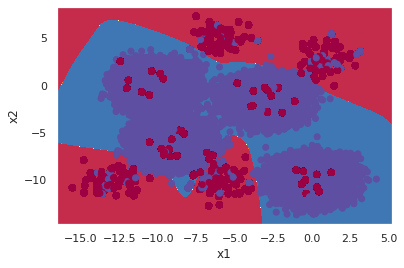

Training model 7
[1,   537] loss: 0.046
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.028
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 110.97976993094198 sec
AUC: 0.8976108102504796
MSE: 0.1029127733702757


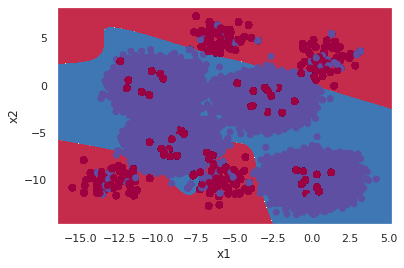

Training model 8
[1,   537] loss: 0.047
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 111.59443891094998 sec
AUC: 0.9002096081217162
MSE: 0.10292883801126321


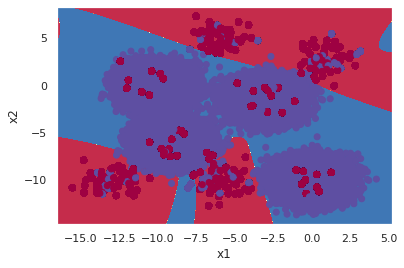

Training model 9
[1,   537] loss: 0.043
[2,   537] loss: 0.031
[3,   537] loss: 0.031
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.030
[7,   537] loss: 0.030
[8,   537] loss: 0.029
[9,   537] loss: 0.029
[10,   537] loss: 0.029
[11,   537] loss: 0.029
[12,   537] loss: 0.029
[13,   537] loss: 0.029
[14,   537] loss: 0.029
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 32.69310113100801 sec
AUC: 0.8987778093620703
MSE: 0.10344665605716023


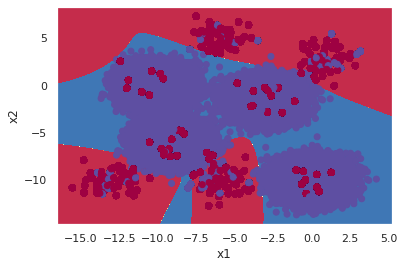

Training model 10
[1,   537] loss: 0.049
[2,   537] loss: 0.031
[3,   537] loss: 0.030
[4,   537] loss: 0.030
[5,   537] loss: 0.030
[6,   537] loss: 0.029
[7,   537] loss: 0.029
[8,   537] loss: 0.029
[9,   537] loss: 0.028
[10,   537] loss: 0.028
[11,   537] loss: 0.028
[12,   537] loss: 0.028
[13,   537] loss: 0.028
[14,   537] loss: 0.028
[15,   537] loss: 0.028
[16,   537] loss: 0.028
[17,   537] loss: 0.028
[18,   537] loss: 0.028
[19,   537] loss: 0.028
[20,   537] loss: 0.028
Finished Training
Train time: 32.68467327405233 sec
AUC: 0.8991493072286907
MSE: 0.10264484986808603


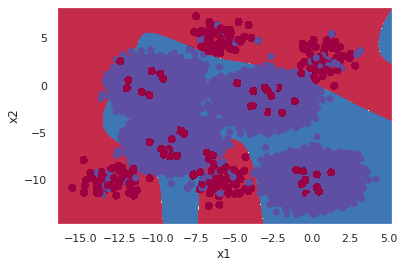

In [119]:
models = []
for i in range(10):
    print(f"Training model {i+1}")
    models.append(train_then_plot(seed = i + 42))

In [127]:
def plot_uncertainty(models, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    scores = []
    for model in models:
        if torch.cuda.is_available():
            Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
            Z = Z.cpu().detach().numpy().reshape(xx.shape)
        else:
            Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])))
            Z = Z.detach().numpy().reshape(xx.shape)
        scores.append(Z)
    ensemble_scores = np.mean(np.array(scores), axis = 0)
    uncertainty = np.std(np.array(scores), axis = 0)
    plt.contourf(xx, yy, ensemble_scores, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Ensemble Predictions")
    
    plt.show()
    
    plt.contourf(xx, yy, uncertainty, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Uncertainty")
    
    plt.show()


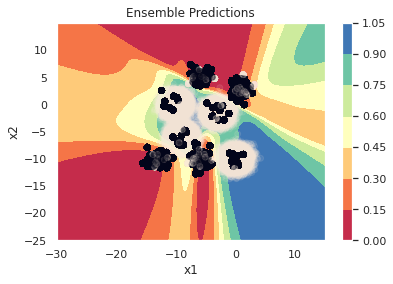

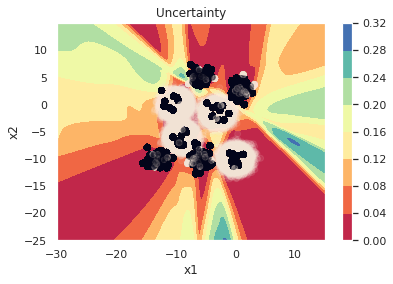

In [128]:
plot_uncertainty(models)

In [122]:
def train_autoencoder(seed = None):
    if seed is not None:
        set_seed(seed)
        

    model = nn.Sequential(nn.Linear(2, 4),
                          nn.Tanh(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 4),
                          nn.Tanh(),
                          nn.Dropout(0.1),
                          nn.Linear(4, 2))
    
    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_norm, y), batch_size = batch_size,
                                          shuffle = True, num_workers = 2, worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()
    

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

In [123]:
autoencoder = train_autoencoder( seed = 42)

[1,   537] loss: 0.093
[2,   537] loss: 0.035
[3,   537] loss: 0.030
[4,   537] loss: 0.028
[5,   537] loss: 0.028
[6,   537] loss: 0.027
[7,   537] loss: 0.027
[8,   537] loss: 0.027
[9,   537] loss: 0.027
[10,   537] loss: 0.027
[11,   537] loss: 0.027
[12,   537] loss: 0.026
[13,   537] loss: 0.026
[14,   537] loss: 0.026
[15,   537] loss: 0.026
[16,   537] loss: 0.027
[17,   537] loss: 0.026
[18,   537] loss: 0.026
[19,   537] loss: 0.026
[20,   537] loss: 0.026
Finished Training


In [129]:
def plot_misalignment(model, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    
    if torch.cuda.is_available():
        Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
        Z = Z.cpu().detach().numpy()
    else:
        Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])))
        Z = Z.detach().numpy()

    Z = np.sum((Z - scaler2.transform(np.c_[xx.ravel(), yy.ravel()])) ** 2, axis = 1).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Autoencoder Misalignment")
    
    plt.show()

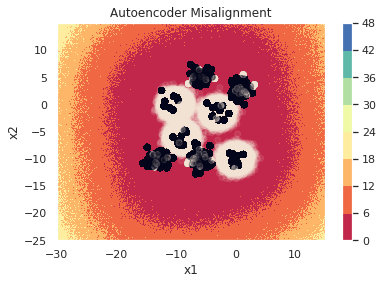

In [130]:
plot_misalignment(autoencoder)

In [126]:
def train_model(seed = None):
    if seed is not None:
        set_seed(seed)

    model = nn.Sequential(nn.Linear(2, 20),
                          nn.Tanh(),
                          nn.Dropout(0.2),
                          nn.Linear(20, 10),
                          nn.Tanh(),
                          nn.Dropout(0.2),
                          nn.Linear(10, 1),
                          nn.Sigmoid())

    use_gpu = torch.cuda.is_available()
    
    if use_gpu:
        model.cuda()

    batch_size = 256
    data_loader = torch.utils.data.DataLoader(get_tensor_dataset(X_norm, y),
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 2, 
                                              worker_init_fn = seed_worker)
    
    criterion = nn.MSELoss()

    optimizer = optim.AdamW(model.parameters())
    
    for epoch in range(20):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))

    print('Finished Training')
    
    return model

def train_then_plot(seed = None):
    start = time.perf_counter()
    net = train_model(seed)
    stop = time.perf_counter()
    print(f"Train time: {stop - start} sec")
    net.eval()
    plot_decision_boundary(net, scaler2, X, y)
    return net

[1,   537] loss: 0.051
[2,   537] loss: 0.036
[3,   537] loss: 0.035
[4,   537] loss: 0.034
[5,   537] loss: 0.033
[6,   537] loss: 0.033
[7,   537] loss: 0.033
[8,   537] loss: 0.032
[9,   537] loss: 0.032
[10,   537] loss: 0.032
[11,   537] loss: 0.032
[12,   537] loss: 0.032
[13,   537] loss: 0.032
[14,   537] loss: 0.032
[15,   537] loss: 0.032
[16,   537] loss: 0.031
[17,   537] loss: 0.031
[18,   537] loss: 0.031
[19,   537] loss: 0.031
[20,   537] loss: 0.031
Finished Training
Train time: 37.992440507980064 sec
AUC: 0.8843266908237013
MSE: 0.1079165545043039


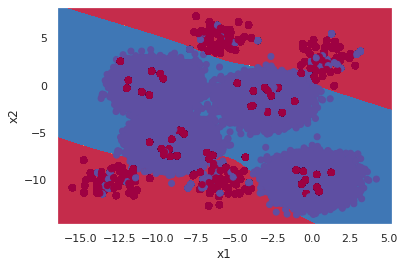

In [131]:
model = train_then_plot(seed = 42)

In [132]:
def plot_uncertainty(model, xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))
    scores = []
    model.eval()
    for m in model.modules():
      if m.__class__.__name__.startswith('Dropout'):
        m.train()
    for _ in range(10):
        if torch.cuda.is_available():
            Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])).cuda())
            Z = Z.cpu().detach().numpy().reshape(xx.shape)
        else:
            Z = model(torch.Tensor(scaler2.transform(np.c_[xx.ravel(), yy.ravel()])))
            Z = Z.detach().numpy().reshape(xx.shape)
        scores.append(Z)
    ensemble_scores = np.mean(np.array(scores), axis = 0)
    uncertainty = np.std(np.array(scores), axis = 0)
    plt.contourf(xx, yy, ensemble_scores, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Ensemble Predictions")
    
    plt.show()
    
    plt.contourf(xx, yy, uncertainty, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Uncertainty")
    
    plt.show()

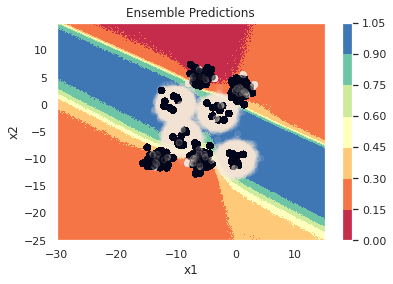

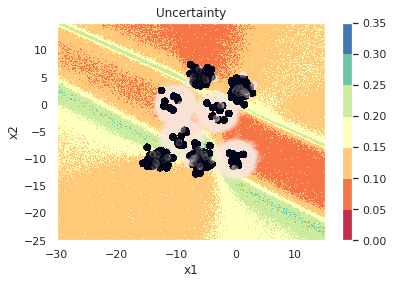

In [133]:
plot_uncertainty(model)

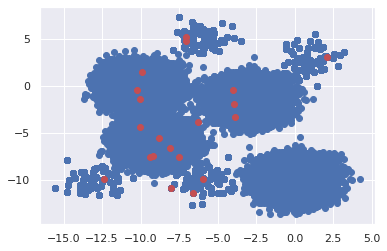

In [134]:
samples_idx = np.random.choice(X.shape[0], 20, replace=False)
samples = X[samples_idx]

plt.scatter(X[:,0], X[:,1])
plt.scatter(samples[:,0], samples[:,1], c = "r")
plt.show()

In [135]:
def get_min_dist(x):
    dist = np.min(np.linalg.norm(x[:, None, :] - samples[None, :, :], axis = -1), axis = 1)
    return dist

def plot_dist(xmin = -30, xmax = 15, ymin = -25, ymax = 15, restrict = False):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

    Z = get_min_dist(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.colorbar()
    plt.scatter(X[:,0],
                X[:,1],
                c = y, alpha = 0.1)
    if restrict:
        plt.xlim([xmin, xmax])
        plt.ylim([ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title("Sample Distance-Based Outlier Factor")
    
    plt.show()

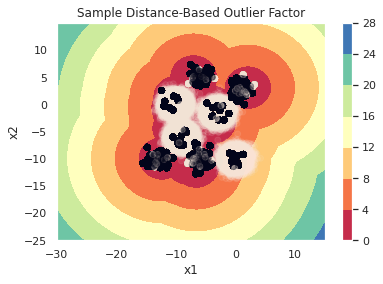

In [136]:
plot_dist()